In [1]:
from utils import *

import cellxgene_census
from cellxgene_census.experimental.ml import ExperimentDataPipe, experiment_dataloader
import somacore as soma
from somacore import AxisQuery
import torch
from torch.utils.data import DataLoader
torch.ones(2).cuda();

### [Papermill](https://papermill.readthedocs.io/en/latest/) params:

In [2]:
# Set to None to fetch from S3
census_uri = '/mnt/nvme/s3/cellxgene-census-public-us-west-2/cell-census/2023-12-15/soma'

# Slice 138 total datasets
start = 2
end = 7

n_epochs = 1
BATCH_SIZE = 1024
n_vars = 20_000
SOMA_CHUNK_SIZE = 10_000

# Misc
peek_dataset_lens = None  # When set, initialize loaders and print `len`s for the first [this many] datasets

# Plot configs
period = 10  # Color batch timings by this modulus (to highlight periodic artifacts)
ann_cutoff = .5  # Annotate plot with values for batch timings greater than this threshold
log_plot = False
width = 1200
height = 700

In [3]:
# Parameters
census_uri = ""


In [4]:
if not census_uri:
    census_uri = None
if census_uri and census_uri.startswith('/'):
    census_loc = 'local'
else:
    census_loc = 'S3'
err(f"Using {census_loc} census")

Using S3 census


In [5]:
census = cellxgene_census.open_soma(uri=census_uri)

#reference = ln.Collection.filter(uid="1gsdckxvOvIjQgeDVS1F").one().reference
reference = '283d65eb-dd53-496d-adb7-7570c7caa443'
query_collection_id = f"collection_id == '{reference}'"
datasets =(census["census_info"]["datasets"]
           .read(column_names=["dataset_id"], value_filter=query_collection_id)
           .concat().to_pandas())["dataset_id"].tolist()
datasets[:10]

The "stable" release is currently 2023-12-15. Specify 'census_version="2023-12-15"' in future calls to open_soma() to ensure data consistency.


['8e10f1c4-8e98-41e5-b65f-8cd89a887122',
 'b165f033-9dec-468a-9248-802fc6902a74',
 'ff7d15fa-f4b6-4a0e-992e-fd0c9d088ded',
 'fe1a73ab-a203-45fd-84e9-0f7fd19efcbd',
 'fbf173f9-f809-4d84-9b65-ae205d35b523',
 'fa554686-fc07-44dd-b2de-b726d82d26ec',
 'f9034091-2e8f-4ac6-9874-e7b7eb566824',
 'f8dda921-5fb4-4c94-a654-c6fc346bfd6d',
 'f7d003d4-40d5-4de8-858c-a9a8b48fcc67',
 'f6d9f2ad-5ec7-4d53-b7f0-ceb0e7bcd181']

In [6]:
len(datasets)

138

In [7]:
experiment = census["census_data"]["homo_sapiens"]
experiment

<Experiment 's3://cellxgene-census-public-us-west-2/cell-census/2023-12-15/soma/census_data/homo_sapiens' (open for 'r') (2 items)
    'ms': 's3://cellxgene-census-public-us-west-2/cell-census/2023-12-15/soma/census_data/homo_sapiens/ms' (unopened)
    'obs': 's3://cellxgene-census-public-us-west-2/cell-census/2023-12-15/soma/census_data/homo_sapiens/obs' (unopened)>

In [8]:
@dataclass
class Exp:
    datapipe: ExperimentDataPipe
    loader: DataLoader

In [9]:
def get_exp_datapipe(start=None, end=None) -> Exp:
    ds = datasets[slice(start, end)]
    query_datasets = "dataset_id in " + str(ds)
    experiment_datapipe = ExperimentDataPipe(
        experiment,
        measurement_name="RNA",
        X_name="raw",
        obs_query=AxisQuery(value_filter=query_datasets),
        var_query=AxisQuery(coords=(slice(n_vars-1),)),
        batch_size=BATCH_SIZE,
        shuffle=True,
        soma_chunk_size=SOMA_CHUNK_SIZE,
    )
    loader = experiment_dataloader(experiment_datapipe)
    return Exp(experiment_datapipe, loader)

Optional: peek at `peek_dataset_lens` datasets' lengths:

In [10]:
%%time
if peek_dataset_lens:
    exps_prefix = [ get_exp_datapipe(start=i, n=1) for i in range(10) ]
    print([ exp.datapipe.shape[0] for exp in exps_prefix ])

CPU times: user 15 µs, sys: 5 µs, total: 20 µs
Wall time: 38.6 µs


In [11]:
results = {"Merlin": {}, "MappedCollection": {}, "cellxgene_census": {}}
for epoch in range(n_epochs):
    for k in results:
        results[k][f"epoch_{epoch}"] = {}

In [12]:
@dataclass
class Batch:
    batch: float
    gc: Optional[float] = None

In [13]:
@dataclass
class Epoch:
    time_per_sample: float
    samples_per_sec: float
    batches: list[Batch]

In [14]:
@dataclass
class Method:
    name: str
    epochs: list[Epoch]

In [15]:
@dataclass
class Results:
    census: Method
    merlin: Optional[Method] = None
    mapped_collection: Optional[Method] = None

In [16]:
def benchmark(exp: Exp) -> Epoch:
    n_samples = exp.datapipe.shape[0]
    loader_iter = exp.loader.__iter__()
    # exclude first batch from benchmark as this includes the setup time
    batch = next(loader_iter)
    
    num_iter = n_samples // BATCH_SIZE if n_samples is not None else None
    
    batches = []
    start_time = batch_time = time()
    
    total = num_iter if num_iter is not None else len(loader_iter)
    for i, batch in tqdm(enumerate(loader_iter), total=total):
        X = batch["x"] if isinstance(batch, dict) else batch[0] 
        # for pytorch DataLoader
        # Merlin sends to cuda by default
        if hasattr(X, "is_cuda") and not X.is_cuda:
            X = X.cuda()
        
        if num_iter is not None and i == num_iter:
            break

        batch_elapsed = time() - batch_time

        gc_time = None
        if i % 10 == 0:
            gc_before = time()
            gc.collect()
            gc_time = time() - gc_before

        batches.append(Batch(batch_elapsed, gc_time))
        batch_time = time()
    
    execution_time = time() - start_time
    gc.collect()
    
    time_per_sample = (1e6 * execution_time) / (total * BATCH_SIZE)
    print(f'time per sample: {time_per_sample:.2f} μs')
    samples_per_sec = total * BATCH_SIZE / execution_time
    print(f'samples per sec: {samples_per_sec:.2f} samples/sec')
    
    return Epoch(samples_per_sec=samples_per_sec, time_per_sample=time_per_sample, batches=batches)

In [17]:
%%time
exp = get_exp_datapipe(start=start, end=end)
exp.datapipe.shape[0]

CPU times: user 9.15 s, sys: 2.77 s, total: 11.9 s
Wall time: 10 s


133790

## Run benchmark

In [18]:
%%time
epochs = []
for epoch in range(n_epochs):
    epoch = benchmark(exp)
    epochs.append(epoch)

results = Results(
    census=Method('census', epochs),
)

  0%|                                                                                              | 0/130 [00:00<?, ?it/s]

  1%|▋                                                                                     | 1/130 [00:00<01:10,  1.83it/s]

  2%|█▎                                                                                    | 2/130 [00:02<02:41,  1.26s/it]

  2%|█▉                                                                                    | 3/130 [00:02<01:33,  1.36it/s]

  3%|██▋                                                                                   | 4/130 [00:02<01:02,  2.03it/s]

  4%|███▎                                                                                  | 5/130 [00:02<00:44,  2.79it/s]

  5%|███▉                                                                                  | 6/130 [00:02<00:33,  3.67it/s]

  5%|████▋                                                                                 | 7/130 [00:02<00:27,  4.55it/s]

  6%|█████▎                                                                                | 8/130 [00:03<00:24,  4.93it/s]

  7%|█████▉                                                                                | 9/130 [00:10<04:51,  2.41s/it]

  8%|██████▌                                                                              | 10/130 [00:10<03:23,  1.70s/it]

  8%|███████▏                                                                             | 11/130 [00:12<03:36,  1.82s/it]

  9%|███████▊                                                                             | 12/130 [00:12<02:33,  1.30s/it]

 10%|████████▌                                                                            | 13/130 [00:12<01:49,  1.07it/s]

 12%|█████████▊                                                                           | 15/130 [00:12<01:03,  1.82it/s]

 12%|██████████▍                                                                          | 16/130 [00:13<00:49,  2.28it/s]

 13%|███████████                                                                          | 17/130 [00:13<00:39,  2.85it/s]

 14%|███████████▊                                                                         | 18/130 [00:19<03:50,  2.05s/it]

 15%|█████████████                                                                        | 20/130 [00:21<02:49,  1.54s/it]

 16%|█████████████▋                                                                       | 21/130 [00:22<02:22,  1.31s/it]

 17%|██████████████▍                                                                      | 22/130 [00:22<01:48,  1.00s/it]

 18%|███████████████                                                                      | 23/130 [00:22<01:23,  1.29it/s]

 18%|███████████████▋                                                                     | 24/130 [00:22<01:03,  1.66it/s]

 19%|████████████████▎                                                                    | 25/130 [00:22<00:49,  2.10it/s]

 20%|█████████████████                                                                    | 26/130 [00:22<00:41,  2.51it/s]

 21%|█████████████████▋                                                                   | 27/130 [00:29<03:56,  2.29s/it]

 22%|██████████████████▉                                                                  | 29/130 [00:31<02:51,  1.69s/it]

 23%|███████████████████▌                                                                 | 30/130 [00:31<02:10,  1.31s/it]

 24%|████████████████████▎                                                                | 31/130 [00:32<01:49,  1.11s/it]

 25%|████████████████████▉                                                                | 32/130 [00:32<01:22,  1.19it/s]

 25%|█████████████████████▌                                                               | 33/130 [00:32<01:02,  1.55it/s]

 26%|██████████████████████▏                                                              | 34/130 [00:32<00:48,  1.98it/s]

 27%|██████████████████████▉                                                              | 35/130 [00:32<00:39,  2.43it/s]

 28%|███████████████████████▌                                                             | 36/130 [00:33<00:32,  2.85it/s]

 28%|████████████████████████▏                                                            | 37/130 [00:40<03:51,  2.49s/it]

 29%|████████████████████████▊                                                            | 38/130 [00:40<02:44,  1.79s/it]

 30%|█████████████████████████▌                                                           | 39/130 [00:42<02:45,  1.82s/it]

 31%|██████████████████████████▏                                                          | 40/130 [00:42<01:58,  1.31s/it]

 32%|██████████████████████████▊                                                          | 41/130 [00:43<01:36,  1.09s/it]

 32%|███████████████████████████▍                                                         | 42/130 [00:43<01:11,  1.23it/s]

 33%|████████████████████████████                                                         | 43/130 [00:43<00:53,  1.62it/s]

 34%|████████████████████████████▊                                                        | 44/130 [00:43<00:42,  2.03it/s]

 35%|█████████████████████████████▍                                                       | 45/130 [00:44<00:36,  2.35it/s]

 35%|██████████████████████████████                                                       | 46/130 [00:55<05:20,  3.81s/it]

 36%|██████████████████████████████▋                                                      | 47/130 [00:56<03:45,  2.71s/it]

 37%|███████████████████████████████▍                                                     | 48/130 [00:57<03:20,  2.45s/it]

 38%|████████████████████████████████                                                     | 49/130 [00:58<02:21,  1.75s/it]

 38%|████████████████████████████████▋                                                    | 50/130 [00:58<01:41,  1.27s/it]

 39%|█████████████████████████████████▎                                                   | 51/130 [00:58<01:24,  1.06s/it]

 40%|██████████████████████████████████                                                   | 52/130 [00:59<01:05,  1.20it/s]

 41%|██████████████████████████████████▋                                                  | 53/130 [00:59<00:53,  1.44it/s]

 42%|███████████████████████████████████▎                                                 | 54/130 [00:59<00:45,  1.67it/s]

 42%|███████████████████████████████████▉                                                 | 55/130 [01:08<03:41,  2.96s/it]

 43%|████████████████████████████████████▌                                                | 56/130 [01:08<02:36,  2.11s/it]

 44%|█████████████████████████████████████▎                                               | 57/130 [01:10<02:24,  1.98s/it]

 45%|█████████████████████████████████████▉                                               | 58/130 [01:10<01:42,  1.43s/it]

 45%|██████████████████████████████████████▌                                              | 59/130 [01:10<01:13,  1.04s/it]

 46%|███████████████████████████████████████▏                                             | 60/130 [01:10<00:53,  1.30it/s]

 47%|███████████████████████████████████████▉                                             | 61/130 [01:11<00:49,  1.39it/s]

 48%|████████████████████████████████████████▌                                            | 62/130 [01:11<00:41,  1.65it/s]

 48%|█████████████████████████████████████████▏                                           | 63/130 [01:11<00:34,  1.92it/s]

 49%|█████████████████████████████████████████▊                                           | 64/130 [01:12<00:29,  2.20it/s]

 50%|██████████████████████████████████████████▌                                          | 65/130 [01:19<02:49,  2.60s/it]

 51%|███████████████████████████████████████████▏                                         | 66/130 [01:19<01:58,  1.86s/it]

 52%|███████████████████████████████████████████▊                                         | 67/130 [01:19<01:24,  1.33s/it]

 52%|████████████████████████████████████████████▍                                        | 68/130 [01:21<01:29,  1.44s/it]

 53%|█████████████████████████████████████████████                                        | 69/130 [01:21<01:04,  1.05s/it]

 54%|█████████████████████████████████████████████▊                                       | 70/130 [01:21<00:46,  1.30it/s]

 55%|██████████████████████████████████████████████▍                                      | 71/130 [01:22<00:41,  1.41it/s]

 55%|███████████████████████████████████████████████                                      | 72/130 [01:22<00:31,  1.83it/s]

 56%|███████████████████████████████████████████████▋                                     | 73/130 [01:22<00:25,  2.22it/s]

 57%|████████████████████████████████████████████████▍                                    | 74/130 [01:34<03:32,  3.79s/it]

 58%|█████████████████████████████████████████████████                                    | 75/130 [01:34<02:28,  2.69s/it]

 58%|█████████████████████████████████████████████████▋                                   | 76/130 [01:36<02:09,  2.40s/it]

 59%|██████████████████████████████████████████████████▎                                  | 77/130 [01:36<01:31,  1.72s/it]

 60%|███████████████████████████████████████████████████                                  | 78/130 [01:36<01:04,  1.24s/it]

 61%|███████████████████████████████████████████████████▋                                 | 79/130 [01:36<00:46,  1.10it/s]

 62%|████████████████████████████████████████████████████▎                                | 80/130 [01:36<00:33,  1.48it/s]

 62%|████████████████████████████████████████████████████▉                                | 81/130 [01:37<00:32,  1.53it/s]

 63%|█████████████████████████████████████████████████████▌                               | 82/130 [01:37<00:26,  1.78it/s]

 64%|██████████████████████████████████████████████████████▎                              | 83/130 [01:44<01:52,  2.39s/it]

 65%|██████████████████████████████████████████████████████▉                              | 84/130 [01:44<01:18,  1.71s/it]

 65%|███████████████████████████████████████████████████████▌                             | 85/130 [01:44<00:55,  1.24s/it]

 66%|████████████████████████████████████████████████████████▏                            | 86/130 [01:46<00:59,  1.35s/it]

 67%|████████████████████████████████████████████████████████▉                            | 87/130 [01:46<00:41,  1.03it/s]

 68%|██████████████████████████████████████████████████████████▏                          | 89/130 [01:46<00:23,  1.75it/s]

 70%|███████████████████████████████████████████████████████████▍                         | 91/130 [01:47<00:18,  2.10it/s]

 71%|████████████████████████████████████████████████████████████▏                        | 92/130 [01:47<00:16,  2.34it/s]

 72%|████████████████████████████████████████████████████████████▊                        | 93/130 [01:55<01:23,  2.27s/it]

 72%|█████████████████████████████████████████████████████████████▍                       | 94/130 [01:55<01:01,  1.72s/it]

 73%|██████████████████████████████████████████████████████████████                       | 95/130 [01:57<01:00,  1.73s/it]

 74%|██████████████████████████████████████████████████████████████▊                      | 96/130 [01:57<00:43,  1.29s/it]

 75%|███████████████████████████████████████████████████████████████▍                     | 97/130 [01:57<00:31,  1.04it/s]

 75%|████████████████████████████████████████████████████████████████                     | 98/130 [01:57<00:22,  1.39it/s]

 76%|████████████████████████████████████████████████████████████████▋                    | 99/130 [01:57<00:16,  1.82it/s]

 77%|████████████████████████████████████████████████████████████████▌                   | 100/130 [01:58<00:12,  2.35it/s]

 78%|█████████████████████████████████████████████████████████████████▎                  | 101/130 [01:58<00:14,  2.03it/s]

 78%|█████████████████████████████████████████████████████████████████▉                  | 102/130 [02:07<01:20,  2.87s/it]

 79%|██████████████████████████████████████████████████████████████████▌                 | 103/130 [02:07<00:55,  2.05s/it]

 80%|███████████████████████████████████████████████████████████████████▏                | 104/130 [02:09<00:51,  1.99s/it]

 81%|███████████████████████████████████████████████████████████████████▊                | 105/130 [02:09<00:35,  1.44s/it]

 82%|████████████████████████████████████████████████████████████████████▍               | 106/130 [02:09<00:25,  1.05s/it]

 82%|█████████████████████████████████████████████████████████████████████▏              | 107/130 [02:09<00:17,  1.29it/s]

 83%|█████████████████████████████████████████████████████████████████████▊              | 108/130 [02:09<00:12,  1.72it/s]

 84%|██████████████████████████████████████████████████████████████████████▍             | 109/130 [02:09<00:09,  2.23it/s]

 85%|███████████████████████████████████████████████████████████████████████             | 110/130 [02:10<00:07,  2.68it/s]

 85%|███████████████████████████████████████████████████████████████████████▋            | 111/130 [02:19<00:56,  2.97s/it]

 86%|████████████████████████████████████████████████████████████████████████▎           | 112/130 [02:20<00:47,  2.62s/it]

 87%|█████████████████████████████████████████████████████████████████████████           | 113/130 [02:21<00:31,  1.87s/it]

 88%|█████████████████████████████████████████████████████████████████████████▋          | 114/130 [02:21<00:21,  1.34s/it]

 88%|██████████████████████████████████████████████████████████████████████████▎         | 115/130 [02:21<00:14,  1.03it/s]

 89%|██████████████████████████████████████████████████████████████████████████▉         | 116/130 [02:21<00:09,  1.40it/s]

 90%|███████████████████████████████████████████████████████████████████████████▌        | 117/130 [02:21<00:06,  1.87it/s]

 91%|████████████████████████████████████████████████████████████████████████████▏       | 118/130 [02:21<00:05,  2.37it/s]

 92%|████████████████████████████████████████████████████████████████████████████▉       | 119/130 [02:21<00:03,  2.90it/s]

 92%|█████████████████████████████████████████████████████████████████████████████▌      | 120/130 [02:22<00:02,  3.34it/s]

 93%|██████████████████████████████████████████████████████████████████████████████▏     | 121/130 [02:29<00:22,  2.47s/it]

 94%|██████████████████████████████████████████████████████████████████████████████▊     | 122/130 [02:29<00:14,  1.77s/it]

 95%|███████████████████████████████████████████████████████████████████████████████▍    | 123/130 [02:29<00:08,  1.27s/it]

 95%|████████████████████████████████████████████████████████████████████████████████    | 124/130 [02:29<00:05,  1.08it/s]

 96%|████████████████████████████████████████████████████████████████████████████████▊   | 125/130 [02:30<00:03,  1.47it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████▍  | 126/130 [02:30<00:02,  1.97it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████  | 127/130 [02:30<00:01,  2.57it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████▋ | 128/130 [02:30<00:00,  3.30it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████▎| 129/130 [02:30<00:00,  4.07it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 130/130 [02:30<00:00,  4.08it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 130/130 [02:30<00:00,  1.16s/it]

time per sample: 1133.39 μs
samples per sec: 882.31 samples/sec
CPU times: user 1min 56s, sys: 56.1 s, total: 2min 52s
Wall time: 2min 51s


In [19]:
results_json_path = f'results-{census_loc}.json'
with open(results_json_path, 'w') as f:
    json.dump(asdict(results), f, indent=2)

In [20]:
# with open(results_json_path, 'r') as f:
#     results = Results(**json.load(f))

## Plot batch timings

In [21]:
method = 'census'
epoch = 0
batches = getattr(results, 'census').epochs[epoch].batches
df = pd.DataFrame(batches)
df.index.name = 'idx'
if period:
    df['res'] = df.index % period
    df['res_str'] = df.res.astype('str') + f'mod{period}'
df = df.reset_index()
df

,idx,batch,gc,res,res_str
0,0,0.106799,0.442309,0,0mod10
1,1,1.766778,NaN,1,1mod10
2,2,0.109591,NaN,2,2mod10
3,3,0.117103,NaN,3,3mod10
4,4,0.120394,NaN,4,4mod10
...,...,...,...,...,...
125,125,0.105348,NaN,5,5mod10
126,126,0.111769,NaN,6,6mod10
127,127,0.104855,NaN,7,7mod10
128,128,0.111742,NaN,8,8mod10


In [22]:
ann = df[df.batch > ann_cutoff] if ann_cutoff else df[[]]
ann

,idx,batch,gc,res,res_str
1,1,1.766778,NaN,1,1mod10
8,8,7.257470,NaN,8,8mod10
10,10,1.645569,0.443089,0,0mod10
17,17,6.600063,NaN,7,7mod10
19,19,1.657098,NaN,9,9mod10
26,26,6.903248,NaN,6,6mod10
28,28,1.850579,NaN,8,8mod10
36,36,7.627467,NaN,6,6mod10
38,38,1.889204,NaN,8,8mod10
45,45,11.729740,NaN,5,5mod10


In [23]:
pc

PlotConfigs(fmt='fig', w=1200, h=800, save=[], v=True, i=None, dir=None, grid='#ccc', bg='white')

Saving: img/census-S3.png


Returning IPython Image


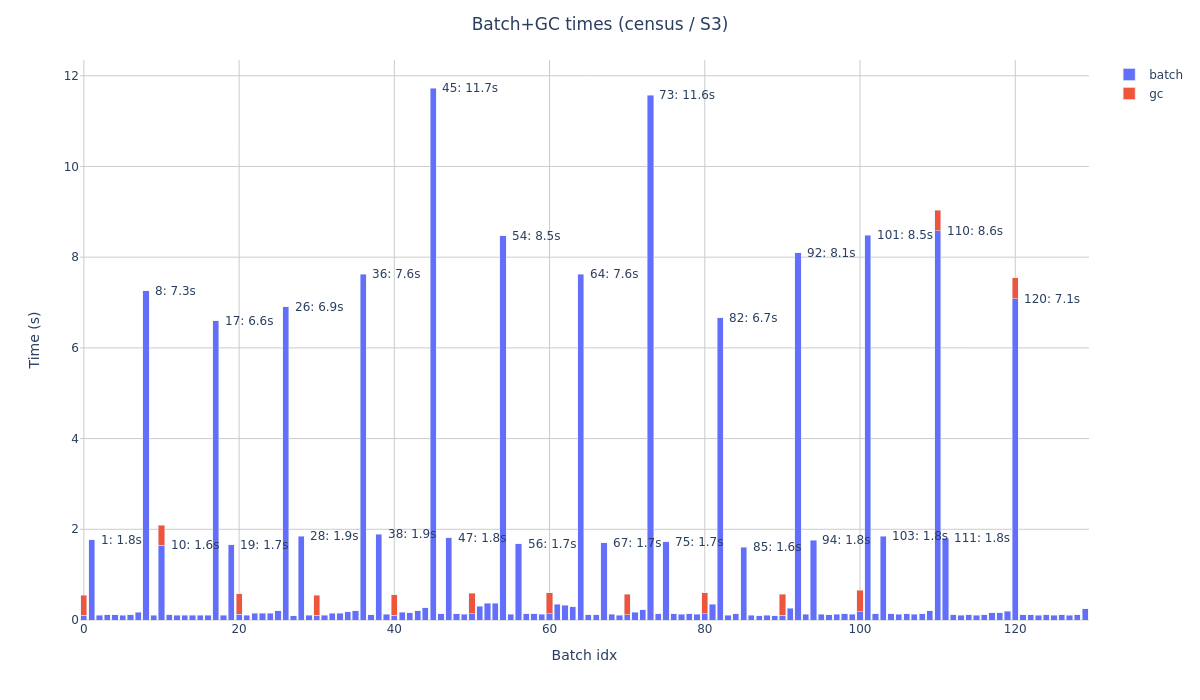

In [24]:
fig = px.bar(
    df.set_index('idx')[['batch', 'gc']],
    barmode='stack',
    labels={
        'idx': 'Batch idx',
        'variable': '',
        'value': 'Time (s)',
    },
    log_y=log_plot,
).update_layout(
    title=dict(text=f'Batch+GC times ({method} / {census_loc})'),
).update_xaxes(
    range=(-.5, len(df) - 1 + .5),
)

if not ann.empty:
    anns = ann.set_index('idx').batch.to_dict().items()
    for idx, batch in anns:
        fig.add_annotation(
            x=idx, y=log10(batch) if log_plot else batch,
            showarrow=False,
            text=f'{idx}: {batch:.1f}s',
            xshift=7,
            xanchor='left',
        )

plot(fig, f'census-{census_loc}', fmt='png', save=['png'], w=width, h=height, dir='img',)